In [1]:
from fastai.vision.all import *
from fastai.callback.tracker import EarlyStoppingCallback
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
path = Path('rps-cv-images')

In [3]:
dls = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2,          # 20% validation set
    seed=42,                # For reproducibility
    item_tfms=Resize(128),   # Resize images to 128x128
    batch_tfms=aug_transforms(size=128, min_scale=0.75) # Data augmentation
)

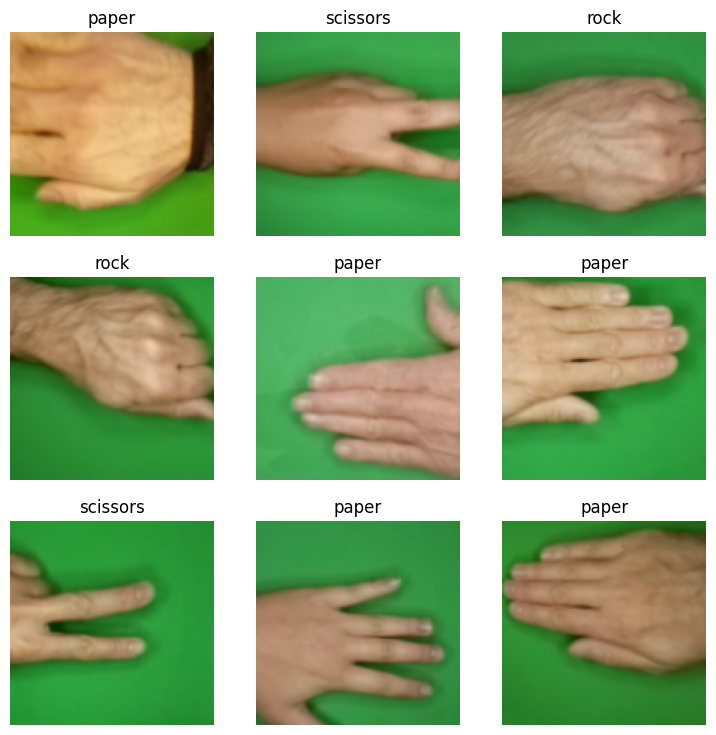

In [4]:
dls.show_batch()

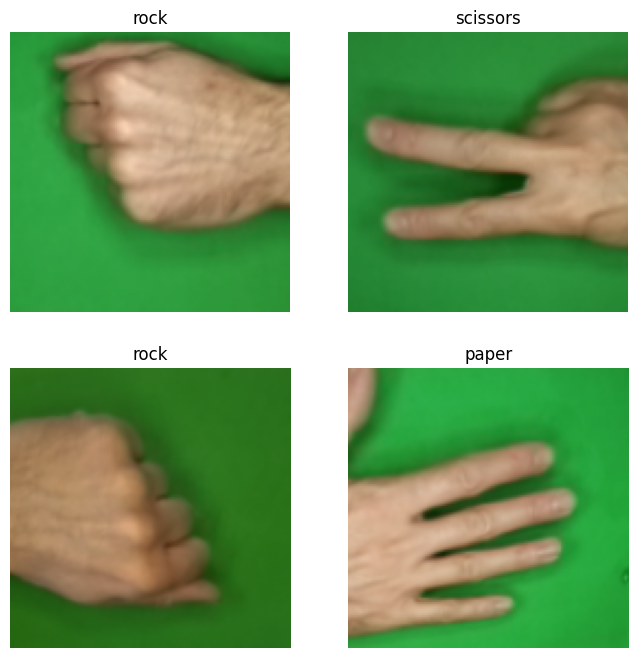

In [5]:
dls.show_batch(max_n=4, figsize=(8,8))

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, use_bias=True):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=use_bias) # Convolutional Layer 1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=use_bias) # Convolutional Layer 2
        self.pool = nn.MaxPool2d(2, 2)                                        # Max Pooling Layer
        self.fc1 = nn.Linear(64 * 32 * 32, 128, bias=use_bias)                  # Fully Connected Layer 1
        self.fc2 = nn.Linear(128, num_classes, bias=use_bias)                   # Fully Connected Layer 2 (output layer)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # Conv1 -> ReLU -> MaxPool
        x = self.pool(F.relu(self.conv2(x))) # Conv2 -> ReLU -> MaxPool
        x = x.view(-1, 64 * 32 * 32)        # Flatten the feature map
        x = F.relu(self.fc1(x))             # FC1 -> ReLU
        x = self.fc2(x)                      # FC2 (output)
        return x

In [7]:
num_classes = len(dls.vocab) # Get number of classes from DataLoaders
model = SimpleCNN(num_classes=num_classes) # Initialize the CNN model


In [8]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy,
                cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=3)]) # Learner with metrics and early stopping


SuggestedLRs(valley=0.0002754228771664202)


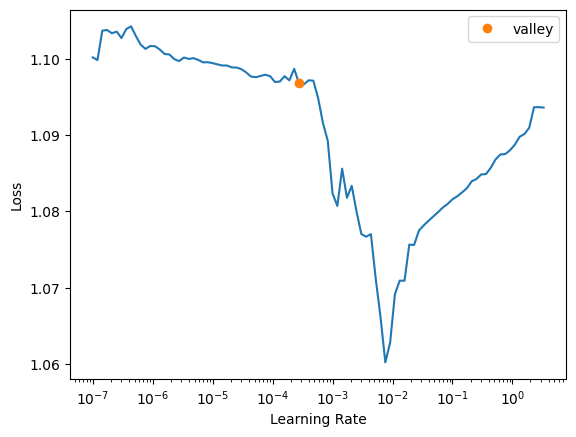

In [9]:
lr_finder = learn.lr_find()
print(lr_finder)

In [12]:
epochs = 20          # Maximum number of epochs
learning_rate = 0.0002754228771664202 # Learning rate based on lr_find()


In [13]:
learn.fine_tune(epochs, base_lr=learning_rate)

epoch,train_loss,valid_loss,accuracy,time
0,1.082964,1.032505,0.487414,00:48


epoch,train_loss,valid_loss,accuracy,time
0,1.010631,0.971702,0.665904,00:48
1,0.992342,0.958918,0.457666,00:47
2,0.972154,0.886092,0.590389,00:45
3,0.947438,0.862461,0.510297,00:46
4,0.918404,0.719254,0.784897,00:47
5,0.878330,0.679042,0.791762,00:47
6,0.829235,0.622421,0.805492,00:46
7,0.779117,0.541664,0.823799,00:46
8,0.747897,0.546537,0.839817,00:45
9,0.707739,0.518695,0.858124,00:45


In [14]:
learn.validate()

(#2) [0.3504751920700073,0.929061770439148]

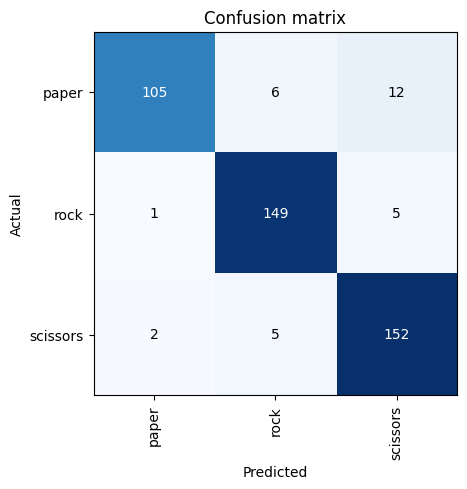

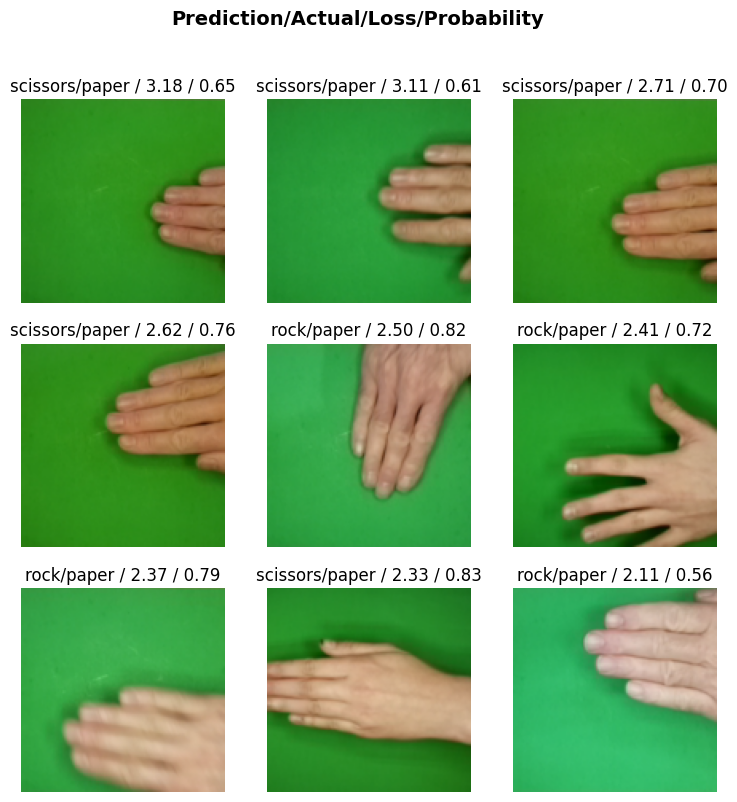

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(k=9)

In [16]:
learn.export() # Exports the trained model as 'export.pkl' in the same directory
print("Model training and evaluation complete. Model exported as 'export.pkl'")

Model training and evaluation complete. Model exported as 'export.pkl'


In [17]:
import cv2
from fastai.learner import load_learner
from fastai.vision.core import PILImage
import torch
import numpy as np

In [18]:
learn_inference = load_learner('rps-cv-images/export.pkl') # Ensure 'export.pkl' is in the same directory or provide the correct path

# Get the category names (rock, paper, scissors) from the DataLoaders vocab
categories = learn_inference.dls.vocab

c:\Users\imehe\miniforge3\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [19]:
cap = cv2.VideoCapture(0) # 0 usually is the default camera, try 1 if you have multiple cameras

if not cap.isOpened():
    raise IOError("Cannot open webcam")

while(True):
    ret, frame = cap.read() # Read a frame from the video capture
    if not ret:
        break # Break the loop if frame is not read correctly

    # Preprocess the frame to be suitable for your model
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Convert BGR (OpenCV default) to RGB
    img_pil = PILImage.create(img_rgb) # Create a PIL Image from the frame
    img_resized = img_pil.resize((128, 128)) # Resize to the size your model expects (e.g., 128x128)

    # Make prediction using your fastai learner
    prediction, _, probabilities = learn_inference.predict(img_resized)
    predicted_class = str(prediction)
    probability_value = float(probabilities[learn_inference.dls.vocab.o2i[predicted_class]])

    # Display prediction information on the frame
    label = f'{predicted_class} {probability_value:.2f}' # e.g., "paper 0.95"
    cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2) # Green text

    # Display the resulting frame
    cv2.imshow('Rock Paper Scissors Detection', frame)

    # Press 'q' to quit the live video feed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture and destroy all windows
cap.release()
cv2.destroyAllWindows()

In [24]:
test_folder_path = Path('Test')

In [25]:
test_image_files = get_image_files(test_folder_path)

print(f"Found {len(test_image_files)} images in the test folder.")

# --- Process and predict for each test image ---
for img_file in test_image_files:
    # 1. Load and Preprocess Image
    img_pil = PILImage.create(img_file) # Load image using PILImage from fastai
    img_resized = img_pil.resize((128, 128)) # Resize to match model input size

    # 2. Make Prediction
    prediction, _, probabilities = learn_inference.predict(img_resized)
    predicted_class = str(prediction)
    probability_value = float(probabilities[learn_inference.dls.vocab.o2i[predicted_class]])

    # 3. Get True Label (from filename - assuming folder structure is like dataset)
    true_label = img_file.parent.name # Assumes images are in folders named 'rock', 'paper', 'scissors'

    # 4. Output Results
    print(f"Image: {img_file.name}")
    print(f"  True Label:     {true_label}")
    print(f"  Predicted Class: {predicted_class}")
    print(f"  Probability:     {probability_value:.4f}") # Display probability with 4 decimal places
    print("-" * 30) # Separator


print("Finished testing on test folder.")

Found 6 images in the test folder.


Image: paper.png
  True Label:     Test
  Predicted Class: paper
  Probability:     1.0000
------------------------------


Image: paper2.png
  True Label:     Test
  Predicted Class: paper
  Probability:     0.6207
------------------------------


Image: rock.png
  True Label:     Test
  Predicted Class: paper
  Probability:     1.0000
------------------------------


Image: rock2.png
  True Label:     Test
  Predicted Class: rock
  Probability:     0.8052
------------------------------


Image: scissor.png
  True Label:     Test
  Predicted Class: paper
  Probability:     1.0000
------------------------------


Image: scissors2.png
  True Label:     Test
  Predicted Class: rock
  Probability:     0.4770
------------------------------
Finished testing on test folder.
